# Ex Chapter 7 LightGBM Breast Cancer

In [2]:
import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_breast_cancer

import matplotlib.pyplot as plt

np.random.seed(42)
%matplotlib inline

In [3]:
# load dataset
breast = load_breast_cancer()
X, y = breast.data, breast.target
feature_name = breast.feature_names

In [8]:
# dataset processing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_test, y_test,reference=lgb_train) # use testing data as the validation set


In [13]:
# Parameters

boost_round = 50  # of iterations
early_stop_rounds = 10
# Create a callback that activates early stopping.（Prevent overfitting）
## Activates early stopping. The model will train until the validation score stops improving.

params = {
    'boosting_type': 'gbdt',  # set boosting
    'objective': 'regression',  # set target function
    'metric': {
        'l2', 'auc'
    },  # evaluation function l2:l2, square loss, aliases: mean_squared_error, mse, regression_l2, regression
    'num_leaves': 31,  # sub leaf nodes,max number of leaves in one tree
    'learning_rate': 0.05,
    'feature_fraction':0.9,  
    # LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0. For example, if you set it to 0.8, LightGBM will select 80% of features before training each tree
    # can be used to speed up training
    # can be used to deal with over-fitting
    'bagging_fraction': 0.8,  # bagging_fraction <= 1.0
    # like feature_fraction, but this will randomly select part of data without resampling
    # can be used to speed up training
    # can be used to deal with over-fitting
    # Note: to enable bagging, bagging_freq should be set to a non zero value as well
    'bagging_freq':5, # bagging in every k iterations
    'verbose' : 1 # controls the level of LightGBM's verbosity
        #< 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug
}

[LightGBM Parameters](https://github.com/microsoft/LightGBM/blob/master/docs/Parameters.rst#num_leaves)

In [12]:
# Training with early stop

results = {}

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=boost_round,
                valid_sets=(lgb_val, lgb_train),
                valid_names=('validate', 'train'),
                early_stopping_rounds=early_stop_rounds,
                evals_result=results)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] Start training from score 0.624176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's auc: 0.98467	train's l2: 0.215503	validate's auc: 0.976779	validate's l2: 0.212784
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	train's auc: 0.986502	train's l2: 0.199142	validate's auc: 0.990478	validate's l2: 0.195826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	train's auc: 0.987933	train's l2: 0.183478	validate's auc: 0.988974	validate's l2: 0.18119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train'

In [15]:
# Prediciton
y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
# y_pred

In [42]:
# Feature Importance LOL

importance_types = list['split', 'gain']

for i in importance_types():
    lgb.plot_importance(gbm, importance_type="i", title=f"Feature importance-{i}",figsize=(6,4))

plt.show()

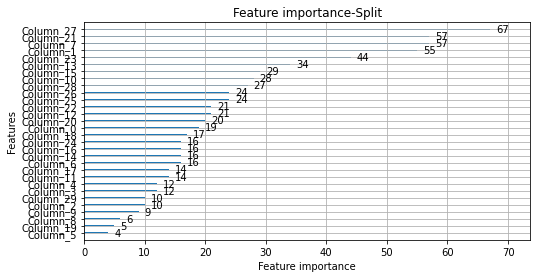

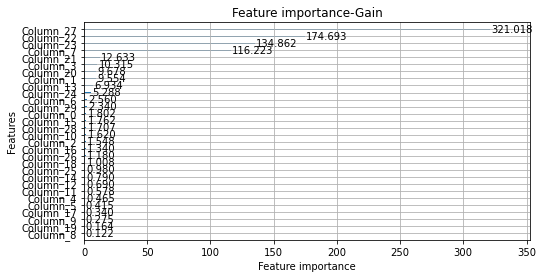

In [46]:
lgb.plot_importance(gbm,
                    importance_type="split",
                    title="Feature importance-Split",
                    figsize=(8, 4))
lgb.plot_importance(gbm,
                    importance_type="gain",
                    title="Feature importance-Gain",
                    figsize=(8, 4))

plt.show()

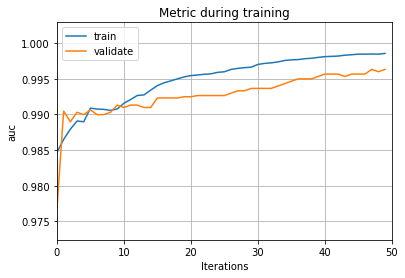

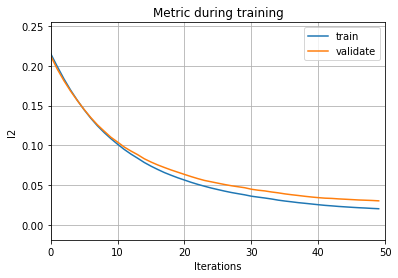

In [49]:
# Model evaluation
lgb.plot_metric(results,metric="auc")
lgb.plot_metric(results, metric="l2")
plt.show()